## NN Adv Assignment

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [70]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [71]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
train['label'].nunique()

10

In [73]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

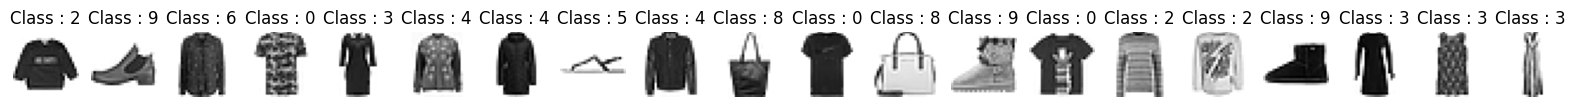

In [75]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [76]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

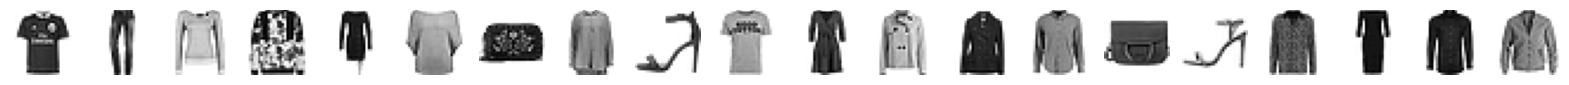

In [77]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [79]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [80]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 256
#Epoch는 고정해주세요.
EPOCHS = 15

In [81]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [82]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [83]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [84]:
X_train.size()

torch.Size([48000, 784])

In [85]:
class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        hidden_dim = 256
        output_dim = 10
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_normal_(self.layer1.weight)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.kaiming_normal_(self.layer2.weight)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim)
        # Dropout
        self.dropout = nn.Dropout(0.5)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.kaiming_normal_(self.layer3.weight)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.batchnorm3(x)
        return x
    
input_dim = 784
model = MyNet().to(DEVICE)
# L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# Loss function
criterion = nn.CrossEntropyLoss()

##### 1) Optimization : Adam 옵티마이저를 사용 + weight_decay를 통해 L2 정규화를 적용하여 모델 파라미터의 크기를 제한
##### 2) Regularization : nn.Dropout을 사용하여 드롭아웃(Dropout) 정규화를 적용
##### 3) Initialization : nn.init.kaiming_normal_ 함수를 사용하여 He Initialization을 적용, 신경망의 층을 초기화 할 때 사용되며, 학습 초기 단계에서 안정적인 학습 
##### 4) Normalization : Batch Normalization,각 미니배치의 입력을 정규화하여 학습을 안정화

[EPOCH: 1], 	Train Loss: 3.1796, 	Train Accuracy: 69.38 %, 	Val Loss: 2.4898, 	Val Accuracy: 84.92 % 

[EPOCH: 2], 	Train Loss: 2.1747, 	Train Accuracy: 85.34 %, 	Val Loss: 1.8193, 	Val Accuracy: 86.85 % 

[EPOCH: 3], 	Train Loss: 1.5468, 	Train Accuracy: 87.10 %, 	Val Loss: 1.2791, 	Val Accuracy: 87.13 % 

[EPOCH: 4], 	Train Loss: 1.1051, 	Train Accuracy: 88.07 %, 	Val Loss: 1.0158, 	Val Accuracy: 87.35 % 

[EPOCH: 5], 	Train Loss: 0.8387, 	Train Accuracy: 88.79 %, 	Val Loss: 0.7594, 	Val Accuracy: 87.97 % 

[EPOCH: 6], 	Train Loss: 0.6683, 	Train Accuracy: 89.72 %, 	Val Loss: 0.6400, 	Val Accuracy: 88.43 % 

[EPOCH: 7], 	Train Loss: 0.5526, 	Train Accuracy: 90.39 %, 	Val Loss: 0.6039, 	Val Accuracy: 87.70 % 

[EPOCH: 8], 	Train Loss: 0.4753, 	Train Accuracy: 90.77 %, 	Val Loss: 0.5158, 	Val Accuracy: 88.82 % 

[EPOCH: 9], 	Train Loss: 0.4120, 	Train Accuracy: 91.51 %, 	Val Loss: 0.4624, 	Val Accuracy: 88.86 % 

[EPOCH: 10], 	Train Loss: 0.3686, 	Train Accuracy: 91.83 %, 	Val Loss: 0.

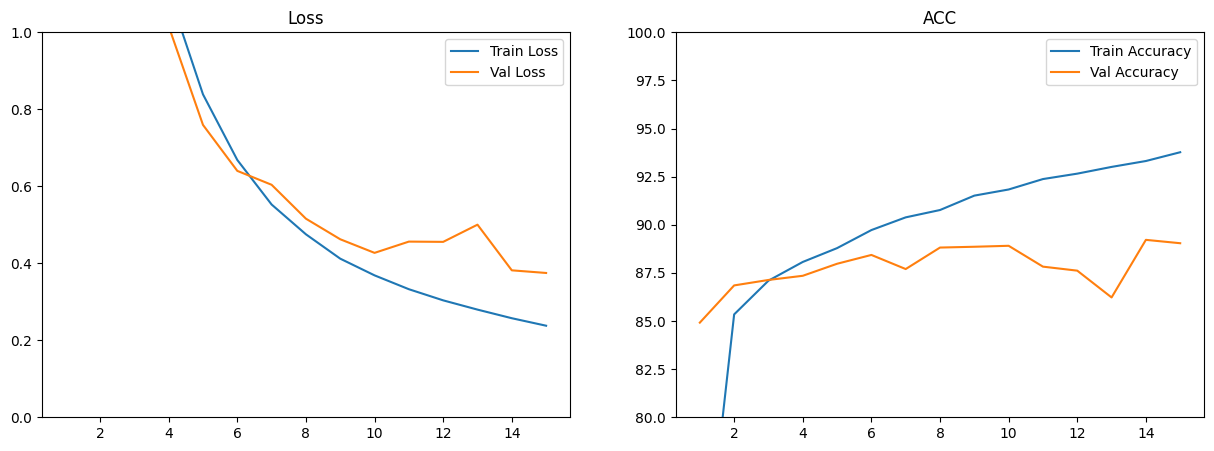

In [86]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

'''
주어진 학습 과정 결과를 종합해 보면, 모델의 성능이 점차적으로 향상되었음을 알 수 있습니다. 초기 에폭부터 마지막 에폭까지 훈련 손실과 훈련 정확도, 그리고 검증 손실과 검증 정확도가 모두 모델의 개선을 보여주었습니다.

처음 에폭에서부터 마지막 에폭까지 훈련 손실은 3.1796에서 0.2378로 큰 감소를 보였습니다. 이로 인해 모델은 훈련 데이터에 대해 잘 적합되었음을 알 수 있습니다. 훈련 정확도도 69.38%에서 시작하여 93.77%로 증가했습니다.

검증 데이터에 대해서도 비슷한 양상을 확인할 수 있습니다. 검증 손실은 2.4898에서 0.3748로 큰 감소를 보였으며, 검증 정확도는 84.92%에서 89.04%로 상승하였습니다. 이는 모델이 더 일반화된 특징을 학습하며 검증 데이터에 대해서도 높은 성능을 보이고 있다는 것을 시사합니다.

따라서, 이 모델은 훈련 데이터와 검증 데이터 모두에서 안정적인 성능 향상을 보여주며, 과적합을 방지하면서 일반화 능력을 향상시켰음을 결론으로 언급할 수 있습니다. 

추가로 그래프를 보면 손실(loss)이 점차 줄어들고 정확도(accuracy)가 점차 증가하는 양상을 보이고 있기 때문에 모델의 학습이 좋은 방향으로 진행되고 있다는 것을 살펴볼 수 있으며, 더 많은 에폭을 사용한다면 성능을 높일 수 있을 것 같다는 생각이 들었습니다. 
'''